# reference https://towardsdatascience.com/time-series-in-python-part-3-forecasting-taxi-trips-with-lstms-277afd4f811

In [26]:
import pandas as pd
import matplotlib.pylab as plt

%matplotlib inline

In [11]:
trips_df = pd.read_csv("fhvhv_tripdata_2019-02.csv")

In [12]:
trips_df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,HV0003,B02867,2019-02-01 00:05:18,2019-02-01 00:14:57,245.0,251.0,NaN
1,HV0003,B02879,2019-02-01 00:41:29,2019-02-01 00:49:39,216.0,197.0,NaN
2,HV0005,B02510,2019-02-01 00:51:34,2019-02-01 01:28:29,261.0,234.0,NaN
3,HV0005,B02510,2019-02-01 00:03:51,2019-02-01 00:07:16,87.0,87.0,NaN
4,HV0005,B02510,2019-02-01 00:09:44,2019-02-01 00:39:56,87.0,198.0,NaN


In [16]:
trips_df["date"] = trips_df["pickup_datetime"].apply(lambda x: x.split()[0])

In [17]:
trips_df.head()

,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag,date
0,HV0003,B02867,2019-02-01 00:05:18,2019-02-01 00:14:57,245.0,251.0,NaN,2019-02-01
1,HV0003,B02879,2019-02-01 00:41:29,2019-02-01 00:49:39,216.0,197.0,NaN,2019-02-01
2,HV0005,B02510,2019-02-01 00:51:34,2019-02-01 01:28:29,261.0,234.0,NaN,2019-02-01
3,HV0005,B02510,2019-02-01 00:03:51,2019-02-01 00:07:16,87.0,87.0,NaN,2019-02-01
4,HV0005,B02510,2019-02-01 00:09:44,2019-02-01 00:39:56,87.0,198.0,NaN,2019-02-01


In [22]:
number_of_trips_per_date = trips_df.groupby(["date"]).size()

In [23]:
number_of_trips_per_date.head()

date
2019-02-01    860161
2019-02-02    866393
2019-02-03    756721
2019-02-04    592170
2019-02-05    576476
dtype: int64

In [24]:
number_of_trips_per_date.tail()

date
2019-02-05    576476
2019-02-06    663516
2019-02-07    649575
2019-02-08    780194
2019-02-09    148388
dtype: int64

In [25]:
number_of_trips_per_date

date
2019-02-01    860161
2019-02-02    866393
2019-02-03    756721
2019-02-04    592170
2019-02-05    576476
2019-02-06    663516
2019-02-07    649575
2019-02-08    780194
2019-02-09    148388
dtype: int64

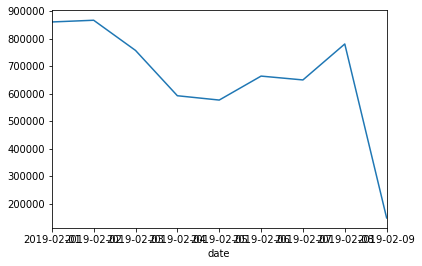

In [27]:
number_of_trips_per_date.plot()

In [1]:
def create_dataset(dataset, look_back=1, forecast_horizon=1, batch_size=1):
    batch_x, batch_y, batch_z = [], [], []
    for i in range(0, len(dataset)-look_back-forecast_horizon-batch_size+1, batch_size):
        for n in range(batch_size):            
            x = dataset[['log_counts','next_is_holiday','next_bad_weather']].values[i+n:(i + n + look_back), :]
            offset = x[0, 0]
            y = dataset['log_counts'].values[i + n + look_back:i + n + look_back + forecast_horizon]
            batch_x.append(np.array(x).reshape(look_back, -1))
            batch_y.append(np.array(y))
            batch_z.append(np.array(offset))
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        batch_z = np.array(batch_z)
        batch_x[:, :, 0] -= batch_z.reshape(-1, 1)
        batch_y -= batch_z.reshape(-1, 1)
        yield batch_x, batch_y, batch_z
        batch_x, batch_y, batch_z = [], [], []

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self, config):
        super(Model, self).__init__()
        self.hidden_size = 128
        self.bi = 1
        self.lstm = nn.LSTM(config.get('features'),self.hidden_size,1,dropout=0.1,bidirectional=self.bi-1,batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size,self.hidden_size // 4,1,dropout=0.1,bidirectional=self.bi-1,batch_first=True)
        self.dense = nn.Linear(self.hidden_size // 4, config.get('forecast_horizon'))
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x, batch_size=100):
        hidden = self.init_hidden(batch_size)
        output, _ = self.lstm(x, hidden)
        output = F.dropout(output, p=0.5, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=0.5, training=True)
        output = self.dense(state[0].squeeze(0))
        
        return output
        
    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size))
        return h0, c0
    
    def init_hidden2(self, batch_size):
        h0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size//4))
        c0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size//4))
        return h0, c0
    
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

In [8]:
# !conda install -c pytorch pytorch -y

In [9]:
batch_size = 1
forecast_horizon = 1
look_back = 28
model = Model(dict(features=3, forecast_horizon=1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5

model.train()
train_true_y = []
train_pred_y = []
for epoch in range(n_epochs):
    ep_loss = []
    for i, batch in enumerate(create_dataset(df[df.index<"2018"], look_back=look_back, forecast_horizon=1, batch_size=batch_size)):
        print("[{}{}] Epoch {}: loss={:0.4f}".format("-"*(20*i//(len(df[df.index<"2018"])//batch_size)), " "*(20-(20*i//(len(df[df.index<"2018"])//batch_size))),epoch, np.mean(ep_loss)), end="\r")
        try:
            batch = [torch.Tensor(x) for x in batch]
        except:
            break

        out = model.forward(batch[0].float(), batch_size)
        loss = model.loss(out, batch[1].float())
        if epoch == n_epochs - 1:
            train_true_y.append((batch[1] + batch[2]).detach().numpy().reshape(-1))
            train_pred_y.append((out + batch[2]).detach().numpy().reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_loss.append(loss.item())
    print()

/Users/joydeepbhattacharjee/miniconda3/envs/venv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


NameError: name 'df' is not defined